# Ocular disease recognition 👀

## Problem Definition

Identify and differentiate ocular disease given structured desensitized ophthalmology image set of patient's age, sex, binocular color fundus photos, and doctors' diagnostic keywords.

## Data

Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.

This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.

The dataset was originally promoted by Peking University in an international competion aiming to provide potential talents who are interested in the development of medical AI product, find and select outstanding innovators, and promote medical AI development in the field of retinal image analysis.

The dataset used can be found on Kaggle usi
ng the following link: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k/data

It can also be found on the site of competition: https://odir2019.grand-challenge.org/

## Goal

> We aim to achieve 90% accuracy on this model

## Evaluation Metric

* Accuracy
* Precision
* Recall
* F1 score

## Features

We have a total of 12 different features on our database that we goona use to build our model, the annotations were labeled by trained human readers with quality control management:

1. Patient Age
2. Patient Sex
5. Left-Diagnostic Keywords (For more precise description for the left eye)
6. Right-Diagnostic Keywords (For more precise description for the right eye)
7. Normal (N),
8. Diabetes (D),
9. Glaucoma (G),
10. Cataract (C),
11. Age related Macular Degeneration (A),
12. Hypertension (H),
13. Pathological Myopia (M),
14. Other diseases/abnormalities (O)

## Preparing the tools

Import all the tools we need:

In [ ]:
# TensorFlow for building and training neural networks
import tensorflow as tf

# TensorFlow Hub for reusing pre-trained models
import tensorflow_hub as hub

# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt

# System and File Operations
import os

# Displaying Images
from IPython.display import display, Image
from PIL import Image

# Splitting data for training and testing
from sklearn.model_selection import train_test_split

# Model Evaluation
from sklearn.metrics import confusion_matrix, classification_report



from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers


# Pre-trained models for transfer learning
from tensorflow.keras.applications import MobileNetV2, ResNet152, InceptionV3, DenseNet201


from sklearn.utils.class_weight import compute_class_weight

from keras.models import load_model

from sklearn.ensemble import VotingClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from collections import Counter
from sklearn.utils import class_weight

import seaborn as sns

import PIL

from sklearn.utils.class_weight import compute_class_weight

# Para stacking
from sklearn.linear_model import LinearRegression

## Load data

The images are split in different folders, so we need to make different paths to get'em;

First acess the train folders:

In [ ]:
# Caminho para o diretório que contém suas pastas de treino, validação e teste
base_dir = 'drive/My Drive/Chest_X-Ray_Pneumonia_Detection/chest_xray'

# Configurar o ImageDataGenerator para pré-processamento de imagens
data_generator = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    brightness_range=[0.6,1],
    zoom_range=0.05,
    fill_mode='nearest'
)

# Create an ImageDataGenerator object for the test set
test_data_generator = ImageDataGenerator(rescale=1./255.)

In [ ]:
# Establish batch size constant
BATCH_SIZE = 32

# Criar geradores de dados de treino, validação e teste
train_generator = data_generator.flow_from_directory(
    directory=f'{base_dir}/train',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    seed=42,
    class_mode='categorical',
    shuffle=True
)

val_generator = data_generator.flow_from_directory(
    directory=f'{base_dir}/val',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    seed=42,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_data_generator.flow_from_directory(
    directory=f'{base_dir}/test',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    seed=42,
    class_mode='categorical',
    shuffle=False
)

Found 4349 images belonging to 2 classes.
Found 892 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
def calculate_class_distribution(generator):
    # Get the classes
    classes = generator.classes

    # Calculate the distribution of classes
    class_distribution = dict(zip(generator.class_indices.keys(), [list(classes).count(c) for c in set(classes)]))

    # Calculate the percentage of each class
    total_samples = len(classes)
    class_percentage = {key: value / total_samples * 100 for key, value in class_distribution.items()}

    # Print the distribution of classes and percentages
    print("Class Distribution:")
    for key in class_distribution:
        print(f"{key}: Count={class_distribution[key]}, Percentage={class_percentage[key]:.2f}%")

# Check training data
calculate_class_distribution(train_generator)

# Check validation data
calculate_class_distribution(val_generator)

# Check test data
calculate_class_distribution(test_generator)

Class Distribution:
normal: Count=1056, Percentage=24.28%
pneumonia: Count=3293, Percentage=75.72%
Class Distribution:
normal: Count=293, Percentage=32.85%
pneumonia: Count=599, Percentage=67.15%
Class Distribution:
normal: Count=234, Percentage=37.50%
pneumonia: Count=390, Percentage=62.50%


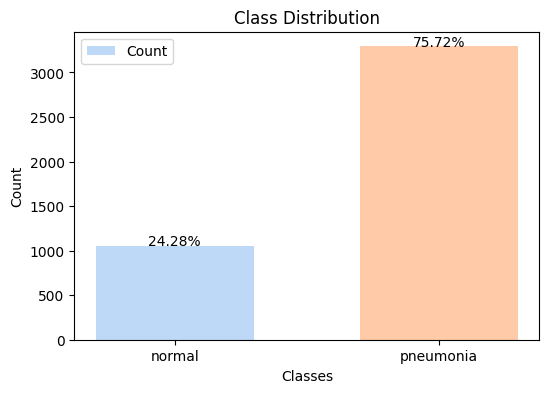

In [ ]:
# Plot a bar to view class distribution
def plot_class_distribution(generator):
    # Get the classes
    classes = generator.classes

    # Calculate the distribution of classes
    class_distribution = dict(zip(generator.class_indices.keys(), [list(classes).count(c) for c in set(classes)]))

    # Calculate the percentage of each class
    total_samples = len(classes)
    class_percentage = {key: value / total_samples * 100 for key, value in class_distribution.items()}

    # Set a more visually appealing color palette
    colors = sns.color_palette("pastel", len(class_distribution))

    # Plot the bar chart with a narrower width and updated colors
    plt.figure(figsize=(6, 4))
    plt.bar(class_distribution.keys(), class_distribution.values(), width=0.6, color=colors, alpha=0.7, label='Count')
    plt.ylabel('Count')
    plt.xlabel('Classes')
    plt.title('Class Distribution')
    plt.legend()

    # Show the percentages on top of the bars
    for key, value in class_distribution.items():
        plt.text(key, value + 5, f'{class_percentage[key]:.2f}%', ha='center')

    # Display the plot
    plt.show()

# Plot for training data
plot_class_distribution(train_generator)

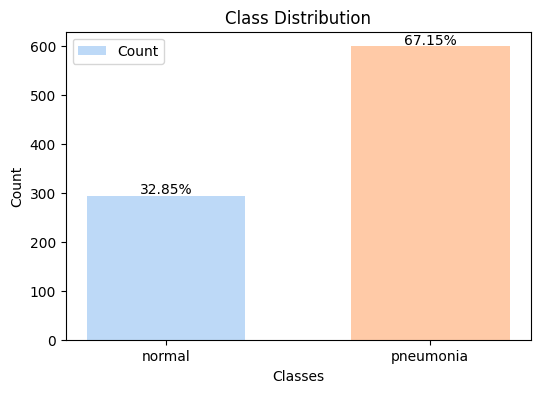

In [ ]:
# Plot for validation data
plot_class_distribution(val_generator)

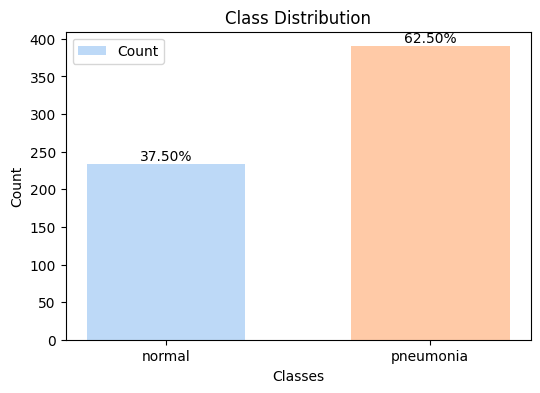

In [ ]:
# Plot for test data
plot_class_distribution(test_generator)

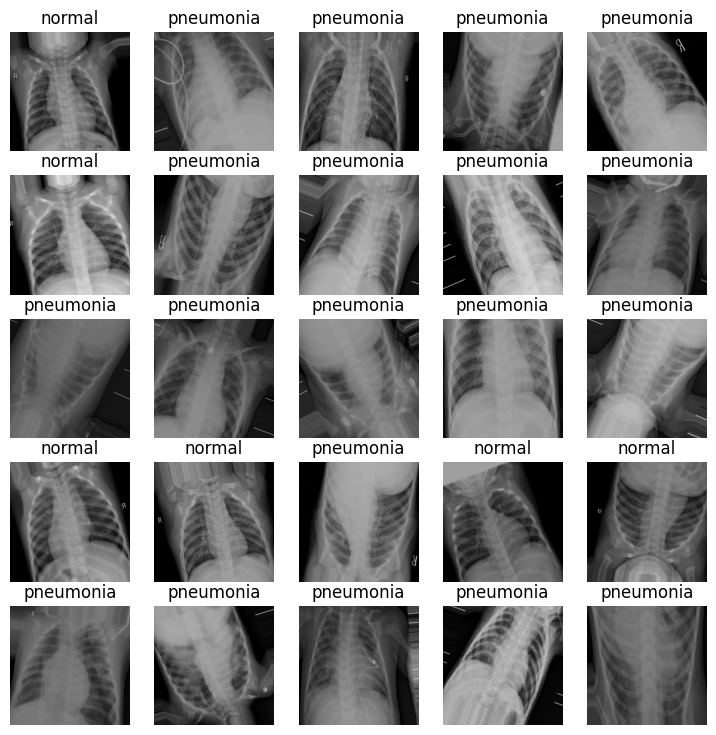

In [ ]:
# Define a function to visualize the images:
def visualize_images(generator, num_images=25):

    # Generate a batch of images and labels from the generator
    images, labels = next(generator)

    # Extract class names from generator
    class_names = list(generator.class_indices.keys())

    # Setup the figure
    plt.figure(figsize=(9, 9))

    # Loop through the number of images
    for i in range(num_images):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i+1)

        # Display an image
        plt.imshow(images[i])

        # Add the image label as the title
        plt.title(class_names[labels[i].argmax()])

        # Turn grid lines off
        plt.axis('off')

# Call function on the training set
visualize_images(train_generator)

## Setting up callbacks

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_delta=0.0001,
    min_lr=0.0000001
)

In [ ]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    min_delta=0.0001,
   #baseline=0.5,
    restore_best_weights=True,
    verbose=2,
    mode='auto'
    )

### Check GPU availability

In [ ]:
# Check GPU availability
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jan 27 16:14:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Build model

In [ ]:
# Calculate the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

# Create a dictionary of class weights
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# Create the Sequential model
model = tf.keras.Sequential([
        ResNet152(input_shape=(224, 224, 3), include_top=False, weights='imagenet'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),
    ])

# Add Dense layers with regularizer using a loop
for num_units in [1024, 562, 256, 128, 64]: # 1024, 562, 256, 128, 64
        model.add(tf.keras.layers.Dense(units=num_units, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1)))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.5))

# Add the final output layer
model.add(tf.keras.layers.Dense(units=2, activation='softmax'))

# Set the model name
model._name = 'ResNet152'

# Compile the model
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
    metrics=['accuracy']
)

234698864/234698864 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "ResNet152"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0 

In [ ]:
# Train the second model using the provided data generators and callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE, # Divide by the batchs_size
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=100,
    shuffle=True,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stopping]
    )

Epoch 1/100
135/135 [==============================] - 1045s 6s/step - loss: 244.4527 - accuracy: 0.5131 - val_loss: 220.3257 - val_accuracy: 0.3275 - lr: 1.0000e-04
Epoch 2/100
135/135 [==============================] - 189s 1s/step - loss: 200.1412 - accuracy: 0.5539 - val_loss: 180.2868 - val_accuracy: 0.5579 - lr: 1.0000e-04
Epoch 3/100
135/135 [==============================] - 173s 1s/step - loss: 162.5004 - accuracy: 0.6500 - val_loss: 145.2426 - val_accuracy: 0.6690 - lr: 1.0000e-04
Epoch 4/100
135/135 [==============================] - 187s 1s/step - loss: 129.4577 - accuracy: 0.7487 - val_loss: 114.6765 - val_accuracy: 0.6690 - lr: 1.0000e-04
Epoch 5/100
135/135 [==============================] - 172s 1s/step - loss: 101.1569 - accuracy: 0.7992 - val_loss: 88.8248 - val_accuracy: 0.6713 - lr: 1.0000e-04
Epoch 6/100
135/135 [==============================] - 190s 1s/step - loss: 77.5816 - accuracy: 0.8478 - val_loss: 67.6906 - val_accuracy: 0.6701 - lr: 1.0000e-04
Epoch 7/100


In [ ]:
def plot_history(history):
    # Get training and validation loss values
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get training and validation accuracy values (if applicable)
    if 'accuracy' in history.history:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

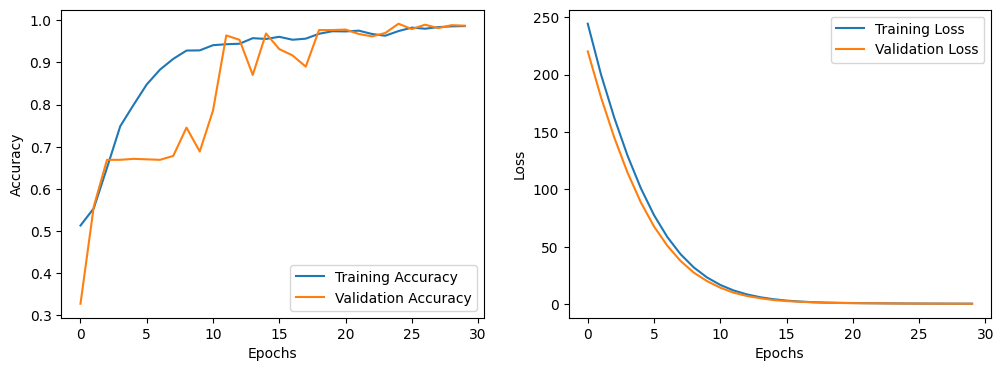

In [ ]:
plot_history(history)

### Save and load the model

In [ ]:
# Save the model
model.save('drive/My Drive/Chest_X-Ray_Pneumonia_Detection/model.keras')

In [ ]:
# Load the model
model = load_model('drive/My Drive/Chest_X-Ray_Pneumonia_Detection/model.keras')

### Evaluate the model

In [ ]:
test_generator.reset()

In [ ]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {accuracy*100:.2f}%')

20/20 [==============================] - 215s 11s/step - loss: 0.6752 - accuracy: 0.9167
Test Accuracy: 91.67%


In [ ]:
def evaluate_model(model, generator):
    # Generate predictions
    y_pred = model.predict(generator)
    y_true = generator.classes

    # Get class labels
    class_labels = list(generator.class_indices.keys())

    # Generate classification report
    report = classification_report(y_true, y_pred.argmax(axis=1), target_names=class_labels, output_dict=True, zero_division=1)

    # Print the classification report
    print(classification_report(y_true, y_pred.argmax(axis=1), target_names=class_labels, zero_division=1))

    # Plot the classification report
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow([[report[label][metric] for metric in ['precision', 'recall', 'f1-score']] for label in class_labels], cmap="YlGnBu")

    ax.set_xticks([0, 1, 2])
    ax.set_yticks(range(len(class_labels)))
    ax.set_xticklabels(['Precision', 'Recall', 'F1-Score'])
    ax.set_yticklabels(class_labels)

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax, cmap="YlGnBu")
    cbar.ax.set_ylabel('Score', rotation=-90, va="bottom")

    # Show plot
    plt.show()

20/20 [==============================] - 18s 540ms/step
              precision    recall  f1-score   support

      normal       0.84      0.96      0.90       234
   pneumonia       0.97      0.89      0.93       390

    accuracy                           0.92       624
   macro avg       0.91      0.93      0.91       624
weighted avg       0.92      0.92      0.92       624



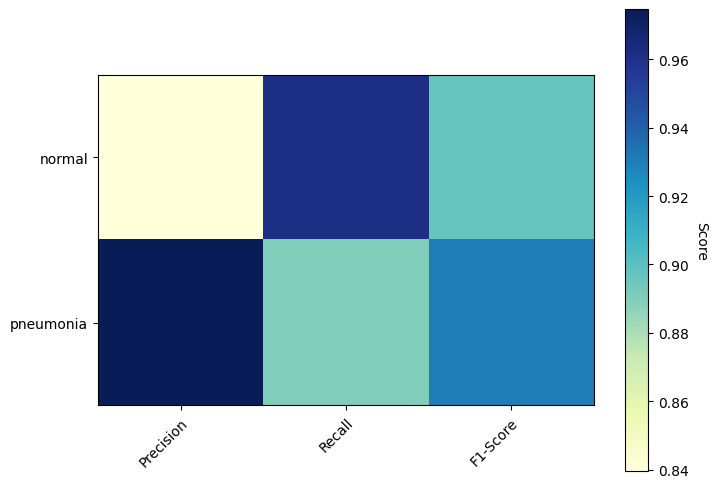

In [ ]:
# Call evaluation function
evaluate_model(model, test_generator)

## Build second model

In [ ]:
# Create the Sequential model
model_two = tf.keras.Sequential([
        InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),
    ])

# Add Dense layers with regularizer using a loop
for num_units in [1024, 512, 256, 128]: #1024, 512, 256, 128
        model_two.add(tf.keras.layers.Dense(units=num_units, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1)))
        model_two.add(tf.keras.layers.BatchNormalization())
        model_two.add(tf.keras.layers.Dropout(0.5))

# Add the final output layer
model_two.add(tf.keras.layers.Dense(units=2, activation='softmax'))

# Set the model name
model_two._name = 'model_two'

# Compile the model
model_two.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
    metrics=['accuracy']
)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
model_two.summary()

Model: "model_two"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization_94 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0 

In [ ]:
# Train the second model using the provided data generators and callbacks
history_two = model_two.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE, # Divide by the batchs_size
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=100,
    shuffle=True,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stopping]
    )

Epoch 1/100
135/135 [==============================] - 1214s 8s/step - loss: 232.1122 - accuracy: 0.5515 - val_loss: 209.4291 - val_accuracy: 0.6794 - lr: 1.0000e-04
Epoch 2/100
135/135 [==============================] - 154s 1s/step - loss: 189.9397 - accuracy: 0.7318 - val_loss: 170.3636 - val_accuracy: 0.7905 - lr: 1.0000e-04
Epoch 3/100
135/135 [==============================] - 155s 1s/step - loss: 152.6269 - accuracy: 0.8436 - val_loss: 135.2030 - val_accuracy: 0.9132 - lr: 1.0000e-04
Epoch 4/100
135/135 [==============================] - 152s 1s/step - loss: 120.1049 - accuracy: 0.8867 - val_loss: 105.3919 - val_accuracy: 0.9132 - lr: 1.0000e-04
Epoch 5/100
135/135 [==============================] - 139s 1s/step - loss: 92.7497 - accuracy: 0.9199 - val_loss: 80.7069 - val_accuracy: 0.9225 - lr: 1.0000e-04
Epoch 6/100
135/135 [==============================] - 137s 1s/step - loss: 70.5636 - accuracy: 0.9236 - val_loss: 60.9487 - val_accuracy: 0.9456 - lr: 1.0000e-04
Epoch 7/100
1

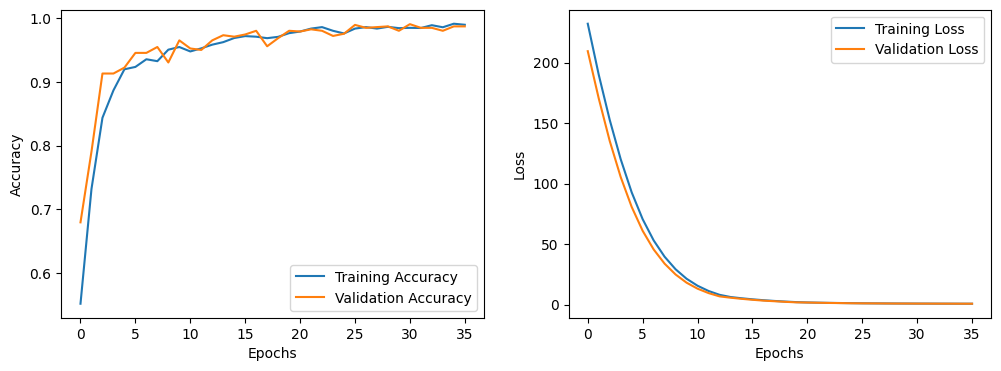

In [ ]:
plot_history(history_two)

### Save and load model_two

In [ ]:
# Save the model
model_two.save('drive/My Drive/Chest_X-Ray_Pneumonia_Detection/model_two.keras')

In [ ]:
# Load the model
model_two = load_model('drive/My Drive/Chest_X-Ray_Pneumonia_Detection/model_two.keras')

20/20 [==============================] - 148s 8s/step
              precision    recall  f1-score   support

      normal       0.90      0.91      0.90       234
   pneumonia       0.95      0.94      0.94       390

    accuracy                           0.93       624
   macro avg       0.92      0.93      0.92       624
weighted avg       0.93      0.93      0.93       624



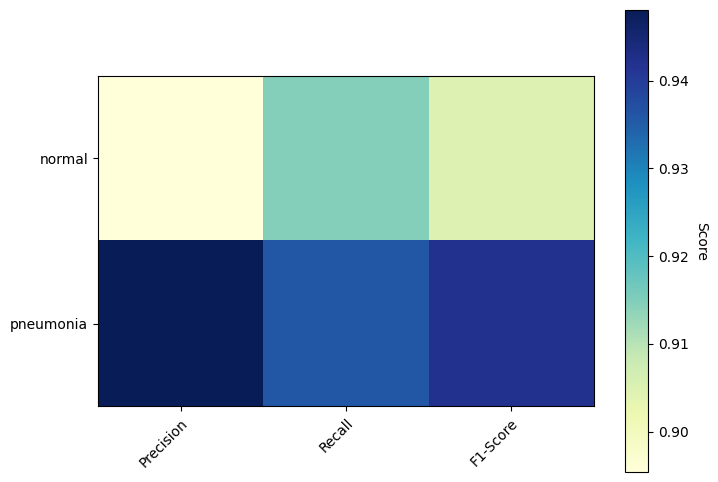

In [ ]:
evaluate_model(model_two, test_generator)

## Build third model

In [ ]:
# Create the Sequential model
model_three = tf.keras.Sequential([
        DenseNet201(input_shape=(224, 224, 3), include_top=False, weights='imagenet'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),
    ])

# Add Dense layers with regularizer using a loop
for num_units in [960, 480, 240, 120]: #960, 480, 240, 120
        model_three.add(tf.keras.layers.Dense(units=num_units, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.1)))
        model_three.add(tf.keras.layers.BatchNormalization())
        model_three.add(tf.keras.layers.Dropout(0.5))

# Add the final output layer
model_three.add(tf.keras.layers.Dense(units=2, activation='softmax'))

# Set the model name
model_three._name = 'model_three'

# Compile the model
model_three.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001),
    metrics=['accuracy']
)

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
model_three.summary()

Model: "model_three"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 960)               1844160   
                                                                 
 batch_normalization (Batch  (None, 960)               3840      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 960)               

In [ ]:
# Train the second model using the provided data generators and callbacks
history_three = model_three.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE, # Divide by the batchs_size
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=100,
    shuffle=True,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stopping]
    )

Epoch 1/100
135/135 [==============================] - 1351s 9s/step - loss: 202.7909 - accuracy: 0.5814 - val_loss: 170.1023 - val_accuracy: 0.7870 - lr: 1.0000e-04
Epoch 2/100
135/135 [==============================] - 179s 1s/step - loss: 147.7272 - accuracy: 0.7137 - val_loss: 127.8390 - val_accuracy: 0.6944 - lr: 1.0000e-04
Epoch 3/100
135/135 [==============================] - 163s 1s/step - loss: 112.5401 - accuracy: 0.8165 - val_loss: 98.6956 - val_accuracy: 0.8299 - lr: 1.0000e-04
Epoch 4/100
135/135 [==============================] - 175s 1s/step - loss: 87.3572 - accuracy: 0.8761 - val_loss: 76.7951 - val_accuracy: 0.9086 - lr: 1.0000e-04
Epoch 5/100
135/135 [==============================] - 157s 1s/step - loss: 67.9936 - accuracy: 0.9050 - val_loss: 59.6347 - val_accuracy: 0.9271 - lr: 1.0000e-04
Epoch 6/100
135/135 [==============================] - 174s 1s/step - loss: 52.7122 - accuracy: 0.9180 - val_loss: 46.2567 - val_accuracy: 0.8438 - lr: 1.0000e-04
Epoch 7/100
135/

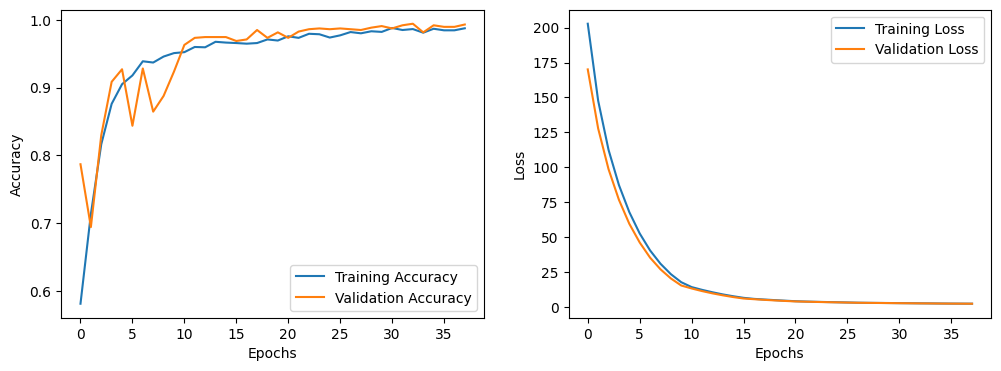

In [ ]:
plot_history(history_three)

### Save and load model_three

In [ ]:
# Save the model
model_three.save('drive/My Drive/Chest_X-Ray_Pneumonia_Detection/model_three.keras')

In [ ]:
# Load the model
model_three = load_model('drive/My Drive/Chest_X-Ray_Pneumonia_Detection/model_three.keras')

20/20 [==============================] - 177s 9s/step
              precision    recall  f1-score   support

      normal       0.92      0.89      0.90       234
   pneumonia       0.94      0.95      0.94       390

    accuracy                           0.93       624
   macro avg       0.93      0.92      0.92       624
weighted avg       0.93      0.93      0.93       624



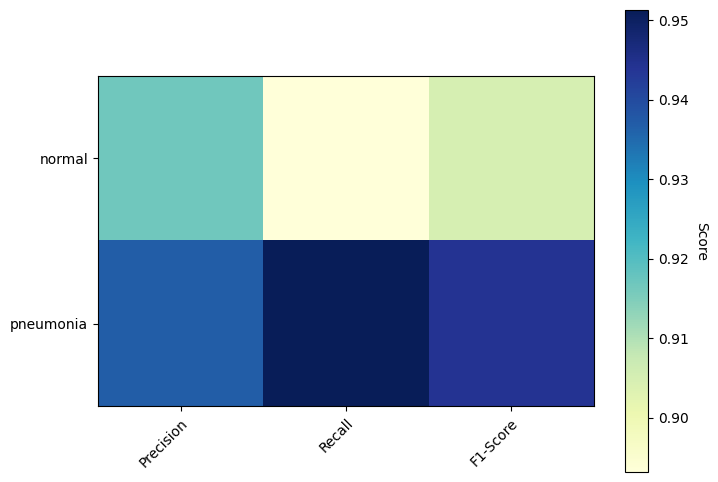

In [ ]:
evaluate_model(model_three, test_generator)